In [1]:
import shutil, os, math, pathlib
def gb(x): return round(x/(1024**3),2)
total, used, free = shutil.disk_usage("/")
print("Disk  Total:", gb(total),"GB  Used:", gb(used),"GB  Free:", gb(free),"GB")
# choose a data dir on a volume with space
DATA_ROOT = pathlib.Path("disaster-ai/data/xbd")
DATA_ROOT.mkdir(parents=True, exist_ok=True)
DATA_ROOT

Disk  Total: 460.43 GB  Used: 126.25 GB  Free: 334.19 GB


PosixPath('disaster-ai/data/xbd')

In [3]:
import sys, importlib
sys.path.append("disaster-ai/src")  # point Python to your src folder

import cv_dataset
importlib.reload(cv_dataset)

print(cv_dataset.CLASSES)

['no-damage', 'minor-damage', 'major-damage', 'destroyed']


Samples in this split: 50
Tensor: torch.Size([3, 224, 224]) | label id: 0 | class: no-damage


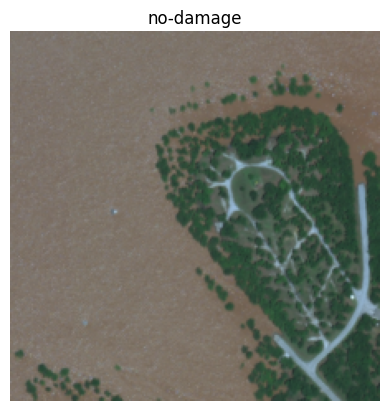

In [5]:
from cv_dataset import XBDDamageDataset, CLASSES
from torchvision import transforms
import matplotlib.pyplot as plt

DATA_SPLIT_DIR = "disaster-ai/data/xbd/tier1"   # or "disaster-ai/data/xbd/train"

ds = XBDDamageDataset(DATA_SPLIT_DIR, split="train", img_size=224, limit=50)
print("Samples in this split:", len(ds))

img, y = ds[0]
print("Tensor:", img.shape, "| label id:", int(y), "| class:", CLASSES[int(y)])

# quick view (rough un-normalize just for display)
to_show = img*0.224 + 0.456
plt.imshow(to_show.permute(1,2,0).clip(0,1))
plt.axis("off"); plt.title(CLASSES[int(y)]); plt.show()

In [7]:
#data-loaders mini batch

In [9]:
# point Python to your src folder (you already did this earlier)
import sys, importlib
sys.path.append("disaster-ai/src")

from cv_dataset import create_dataloaders, CLASSES
import cv_dataset; importlib.reload(cv_dataset)  # pick up any edits

DATA_SPLIT_DIR = "disaster-ai/data/xbd/tier1"   # or "disaster-ai/data/xbd/train"

train_dl, val_dl = create_dataloaders(
    data_dir=DATA_SPLIT_DIR,
    img_size=224,
    batch_size=8,     # drop to 4 if memory is tight
    num_workers=0,    # keep 0 on macOS to avoid spawn issues
    limit=128         # small subset to move fast; remove for full run
)

len(train_dl.dataset), len(val_dl.dataset), CLASSES

(128, 128, ['no-damage', 'minor-damage', 'major-damage', 'destroyed'])

In [11]:
import torch

xb, yb = next(iter(train_dl))
print("Batch images:", xb.shape)      # [B, 3, 224, 224]
print("Batch labels:", yb.shape)      # [B]
print("Label counts in batch:", torch.bincount(yb, minlength=len(CLASSES)))

Batch images: torch.Size([8, 3, 224, 224])
Batch labels: torch.Size([8])
Label counts in batch: tensor([8, 0, 0, 0])


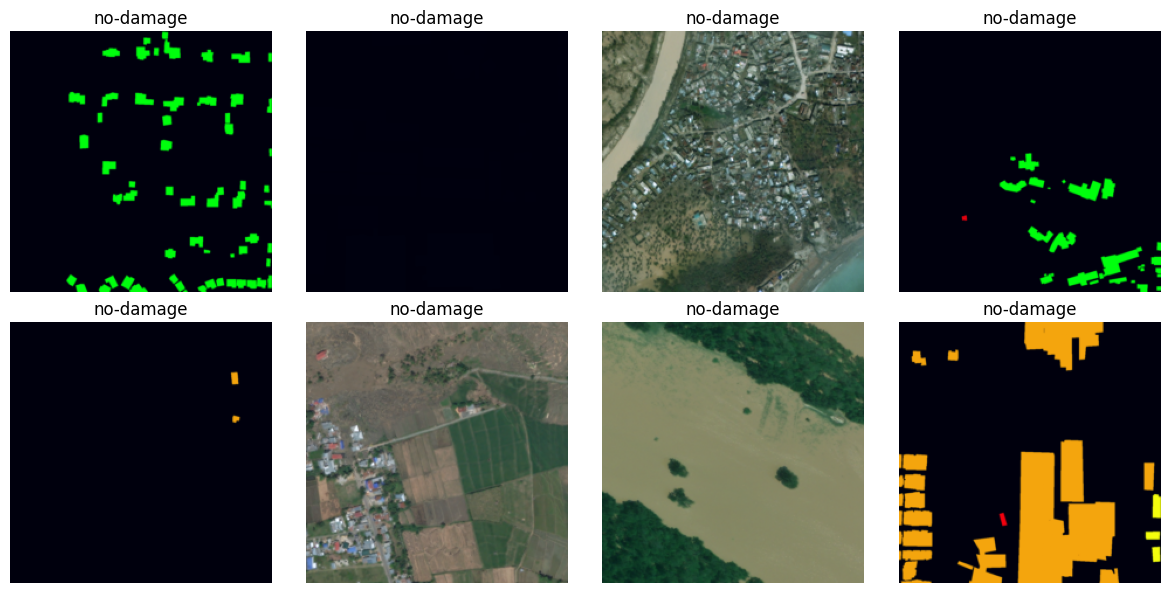

In [13]:
import matplotlib.pyplot as plt

def unnorm(x):
    # quick-and-dirty un-normalization for display
    return (x * 0.224 + 0.456).clamp(0, 1)

rows, cols = 2, 4
plt.figure(figsize=(cols*3, rows*3))
for i in range(rows*cols):
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(unnorm(xb[i]).permute(1,2,0))
    ax.set_title(CLASSES[int(yb[i])])
    ax.axis("off")
plt.tight_layout(); plt.show()

In [23]:
#step 4 - training

In [15]:
import sys, torch, time
from torch import nn
from torchvision.models import resnet18

sys.path.append("disaster-ai/src")
from cv_dataset import create_dataloaders, CLASSES

DATA_SPLIT_DIR = "disaster-ai/data/xbd/tier1"   # or "disaster-ai/data/xbd/train"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

train_dl, val_dl = create_dataloaders(
    data_dir=DATA_SPLIT_DIR,
    img_size=224,
    batch_size=8,     # drop to 4 if memory is tight
    num_workers=0,
    limit=None         # small subset; remove for full training
)

model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss()

Device: mps


In [42]:
import torch
def count_classes(dataloader, n_classes=4):
    counts = torch.zeros(n_classes, dtype=torch.long)
    for _, y in dataloader:
        counts += torch.bincount(y, minlength=n_classes)
    return counts

counts = count_classes(train_dl, len(CLASSES)).float()
weights = (1.0 / (counts + 1e-6))
weights = weights / weights.sum() * len(CLASSES)
print("Class weights:", weights)

loss_fn = torch.nn.CrossEntropyLoss(weight=weights.to(device))

Class weights: tensor([1.9850e-10, 1.3333e+00, 1.3333e+00, 1.3333e+00])


In [44]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from cv_dataset import XBDDamageDataset

# collect labels from the underlying dataset
labels = []
for _, y in train_dl.dataset:   # iterate the dataset, not the loader
    labels.append(int(y))
labels = torch.tensor(labels)

class_counts = torch.bincount(labels, minlength=len(CLASSES)).float()
class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = class_weights[labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

balanced_ds = XBDDamageDataset("disaster-ai/data/xbd/tier1", split="train", img_size=224, seed=42, limit=None)
train_dl = DataLoader(balanced_ds, batch_size=8, sampler=sampler, num_workers=0)

In [46]:
#for train folder 

In [52]:
import sys, torch, time
from torch import nn
from torchvision.models import resnet18

sys.path.append("disaster-ai/src")
from cv_dataset import create_dataloaders, CLASSES

DATA_SPLIT_DIR = "disaster-ai/data/xbd/tier1"   # or "disaster-ai/data/xbd/train"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

train_dl, val_dl = create_dataloaders(
    data_dir=DATA_SPLIT_DIR,
    img_size=224,
    batch_size=8,     # drop to 4 if memory is tight
    num_workers=0,
    limit=None         # small subset; remove for full training
)

model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss()

Device: mps


In [17]:
import sys, importlib, torch
sys.path.append("disaster-ai/src")

import cv_dataset; importlib.reload(cv_dataset)
from cv_dataset import XBDDamageDataset, CLASSES, _find_label_path
from pathlib import Path

DATA_SPLIT_DIR = "disaster-ai/data/xbd/tier1"

ds_train = XBDDamageDataset(DATA_SPLIT_DIR, split="train", img_size=224, seed=42, limit=None)
counts_tr = torch.bincount(
    torch.tensor([int(y) for _, y in ds_train]),
    minlength=len(CLASSES)
).tolist()
print("Train class counts:", counts_tr, "|", CLASSES)

ds_val = XBDDamageDataset(DATA_SPLIT_DIR, split="val", img_size=224, seed=42, limit=None)
counts_va = torch.bincount(
    torch.tensor([int(y) for _, y in ds_val]),
    minlength=len(CLASSES)
).tolist()
print("Val class counts:", counts_va)

Train class counts: [6717, 0, 0, 0] | ['no-damage', 'minor-damage', 'major-damage', 'destroyed']
Val class counts: [1680, 0, 0, 0]


In [21]:
from pathlib import Path
from collections import Counter
import json, random
from cv_dataset import XBDDamageDataset, _find_label_path, CLASS2ID

DATA_SPLIT_DIR = "disaster-ai/data/xbd/tier1"
ds = XBDDamageDataset(DATA_SPLIT_DIR, split="train", img_size=224, seed=42, limit=2000)

def safe_load_json(p: Path):
    """Load JSON and unwrap if it's double-encoded (JSON string inside JSON)."""
    try:
        data = json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return None
    # unwrap at most twice
    for _ in range(2):
        if isinstance(data, str):
            try:
                data = json.loads(data)
            except Exception:
                break
    return data

def read_damage_counts(label_path: Path) -> Counter:
    counts = Counter()
    data = safe_load_json(label_path)
    if not isinstance(data, dict):
        return counts
    feats = data.get("features", [])
    # Some files are weird: features might be a dict or contain strings
    if isinstance(feats, dict):
        feats = feats.get("features", [])
    if not isinstance(feats, list):
        return counts

    for feat in feats:
        if not isinstance(feat, dict):
            continue
        props = feat.get("properties") or {}
        if not isinstance(props, dict):
            continue
        dmg = props.get("subtype") or props.get("damage") or props.get("damage_type")
        if dmg in CLASS2ID:
            counts[dmg] += 1
    return counts

# Probe a random subset of items actually used by the dataset
hits = []
problem_files = []
sample = random.sample(ds.items, min(50, len(ds)))
for p in sample:
    lp = _find_label_path(p)
    if lp and lp.exists():
        try:
            c = read_damage_counts(lp)
            hits.append((p.name, c))
        except Exception:
            problem_files.append(lp)

# Show files with any damage
nonzero = [(n, c) for (n, c) in hits if sum(c.values()) > 0]
for name, c in nonzero[:10]:
    print(name, "=>", dict(c))

print(f"\nChecked {len(hits)} files. Non-zero damage: {len(nonzero)}")
if problem_files:
    print("Malformed label files (skipped):")
    for z in problem_files[:5]:
        print("  -", z)


Checked 20 files. Non-zero damage: 0


In [27]:
from pathlib import Path
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

BIN_CLASSES = ["no-damage", "damage"]

class XBDMaskBinaryDataset(Dataset):
    def __init__(self, root, split="train", img_size=224, seed=42, limit=None):
        root = Path(root)
        self.imgs = sorted(root.rglob("*post*disaster*.png"))  # post-disaster tiles only
        random.seed(seed); random.shuffle(self.imgs)
        n = int(0.8*len(self.imgs))
        self.imgs = self.imgs[:n] if split=="train" else self.imgs[n:]
        if limit: self.imgs = self.imgs[:limit]

        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])

    def __len__(self): 
        return len(self.imgs)

    def _mask_path(self, img_path: Path) -> Path:
        # images/..._post_disaster.png -> masks/..._post_disaster_rgb.png
        if img_path.parent.name == "images":
            return img_path.parent.parent / "masks" / img_path.name.replace(".png", "_rgb.png")
        # fallback: same folder with _rgb suffix
        return img_path.with_name(img_path.stem + "_rgb.png")

    def __getitem__(self, idx):
        ip = self.imgs[idx]
        mp = self._mask_path(ip)

        # image tensor
        x = Image.open(ip).convert("RGB")
        x = self.tf(x)

        # label from mask: 1 if any nonzero pixel in mask, else 0
        y = 0
        if mp.exists():
            m = Image.open(mp).convert("L")
            arr = np.array(m)              # <-- convert PIL -> NumPy
            y = 1 if arr.sum() > 0 else 0  # any nonzero pixel means damage
        return x, torch.tensor(y, dtype=torch.long)

In [29]:
from matplotlib import pyplot as plt

ds = XBDMaskBinaryDataset("disaster-ai/data/xbd/tier1", split="train", img_size=224, limit=32)
pos = neg = 0
for i in range(min(16, len(ds))):
    x, y = ds[i]
    pos += int(y.item()==1); neg += int(y.item()==0)

print("mini sample label counts -> no-damage:", neg, "| damage:", pos)

# visualize one example and its mask path
ip = ds.imgs[0]
mp = ds._mask_path(ip)
print("img:", ip.name)
print("mask exists:", mp.exists(), "|", mp.name)

mini sample label counts -> no-damage: 5 | damage: 11
img: midwest-flooding_00000319_post_disaster.png
mask exists: True | midwest-flooding_00000319_post_disaster_rgb.png


In [31]:
# cell: loaders (binary)
from torch.utils.data import DataLoader

def create_binary_loaders(data_dir, img_size=224, batch_size=8, seed=42, limit=None):
    ds_tr = XBDMaskBinaryDataset(data_dir, "train", img_size, seed, limit)
    ds_va = XBDMaskBinaryDataset(data_dir, "val",   img_size, seed, limit)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0)
    return dl_tr, dl_va

DATA_SPLIT_DIR = "disaster-ai/data/xbd/tier1"   # or .../train
train_dl, val_dl = create_binary_loaders(DATA_SPLIT_DIR, img_size=224, batch_size=8, limit=None)
len(train_dl.dataset), len(val_dl.dataset)

(6717, 1680)

In [33]:
# cell: train
import time, torch
from torch import nn
from torchvision.models import resnet18

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss()

best = 0.0
for ep in range(3):
    t0 = time.time()
    model.train(); total = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward(); opt.step()
        total += loss.item() * xb.size(0)
    tr_loss = total / len(train_dl.dataset)

    model.eval(); correct = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            correct += (preds == yb).sum().item()
    val_acc = correct / len(val_dl.dataset)

    print(f"epoch {ep+1} | train_loss {tr_loss:.4f} | val_acc {val_acc:.3f} | time {time.time()-t0:.1f}s")
    if val_acc > best:
        best = val_acc
        torch.save(model.state_dict(), "disaster-ai/models/cv/resnet18_xbd_binary.pt")

print("Best:", best)

epoch 1 | train_loss 0.4739 | val_acc 0.761 | time 261.7s
epoch 2 | train_loss 0.4357 | val_acc 0.792 | time 261.2s
epoch 3 | train_loss 0.4183 | val_acc 0.794 | time 260.7s
Best: 0.794047619047619


              precision    recall  f1-score   support

   no-damage      1.000     0.552     0.712       773
      damage      0.724     1.000     0.840       907

    accuracy                          0.794      1680
   macro avg      0.862     0.776     0.776      1680
weighted avg      0.851     0.794     0.781      1680



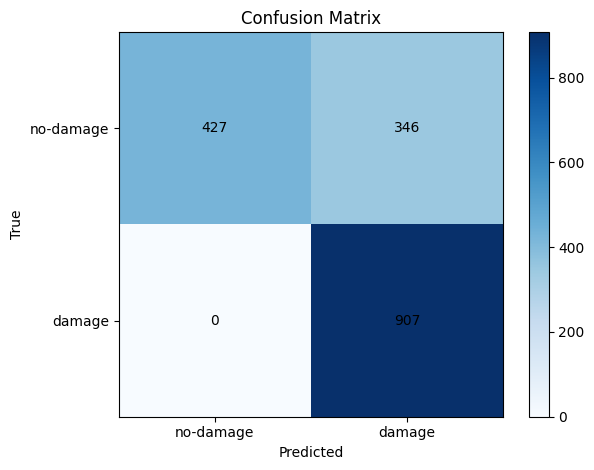

In [35]:
# cell: eval
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

labels = ["no-damage","damage"]
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        probs = model(xb)
        preds = probs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print(classification_report(y_true, y_pred, target_names=labels, digits=3))
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks([0,1], labels); plt.yticks([0,1], labels)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

In [37]:
# compute class weights from the *dataset* (not loader)
counts = torch.bincount(torch.tensor([int(y) for _, y in train_dl.dataset]), minlength=2).float()
class_weights = (1.0 / (counts + 1e-6)) * (2 / (1.0 / (counts + 1e-6)).sum())
print("class counts:", counts.tolist(), "| weights:", class_weights.tolist())

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

class counts: [3142.0, 3575.0] | weights: [1.0644632577896118, 0.9355367422103882]


In [53]:
# cell: dataloaders with augmentation
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF  
from torchvision import transforms
from PIL import Image
import numpy as np 
import torch, json
from pathlib import Path

class XBDMaskBinaryDataset:
    def __init__(self, root, split="train", img_size=224, seed=42, limit=None, aug=False):
        self.root = Path(root)
        self.imgs = sorted(self.root.rglob("*post*disaster*.png"))
        rng = torch.Generator().manual_seed(seed)
        perm = torch.randperm(len(self.imgs), generator=rng)
        n = int(0.8*len(self.imgs))
        self.imgs = [self.imgs[i] for i in perm[:n]] if split=="train" else [self.imgs[i] for i in perm[n:]]
        if limit: self.imgs = self.imgs[:limit]

        tf_train = transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(0.2,0.2,0.2,0.05),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
        tf_eval = transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
        self.tf = tf_train if (aug and split=="train") else tf_eval
        self.aug = aug

    def _mask_path(self, img_path: Path) -> Path:
        # assumes sibling "masks" folder and *_rgb.png masks (as you verified)
        return img_path.parent.parent / "masks" / (img_path.stem + "_rgb.png")

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        ip = self.imgs[idx]
        mp = self._mask_path(ip)
        x = Image.open(ip).convert("RGB")
        m = Image.open(mp).convert("L") if mp.exists() else Image.new("L", x.size)
        y = 1 if TF.pil_to_tensor(m).sum().item() > 0 else 0
        return self.tf(x), torch.tensor(y, dtype=torch.long)

def create_binary_loaders(root, img_size=224, batch_size=16, num_workers=0, limit=None):
    ds_tr = XBDMaskBinaryDataset(root, "train", img_size, aug=True,  limit=limit)
    ds_va = XBDMaskBinaryDataset(root, "val",   img_size, aug=False, limit=limit)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return dl_tr, dl_va

In [55]:
# cell: train longer with a scheduler + early-stopping-ish save-best
import time, torch 
from torch import nn
from torchvision.models import resnet18

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
train_dl, val_dl = create_binary_loaders("disaster-ai/data/xbd/tier1", img_size=224, batch_size=16, limit=None)

model = resnet18(weights=None); model.fc = nn.Linear(model.fc.in_features, 2); model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
loss_fn = nn.CrossEntropyLoss()

best, EPOCHS = 0.0, 10
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    # train
    model.train(); total=0
    for xb,yb in train_dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    tr_loss = total/len(train_dl.dataset)
    sched.step()

    # val
    model.eval(); correct=0
    with torch.no_grad():
        for xb,yb in val_dl:
            xb,yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred==yb).sum().item()
    val_acc = correct/len(val_dl.dataset)
    print(f"epoch {ep:2d} | train_loss {tr_loss:.4f} | val_acc {val_acc:.3f} | time {time.time()-t0:.1f}s")
    if val_acc>best:
        best=val_acc
        torch.save(model.state_dict(), "disaster-ai/models/cv/resnet18_xbd_binary.pt")
print("Best:", best)

epoch  1 | train_loss 0.4660 | val_acc 0.792 | time 259.3s
epoch  2 | train_loss 0.4357 | val_acc 0.791 | time 258.6s
epoch  3 | train_loss 0.4245 | val_acc 0.788 | time 257.9s
epoch  4 | train_loss 0.4131 | val_acc 0.792 | time 256.8s
epoch  5 | train_loss 0.4010 | val_acc 0.792 | time 257.1s
epoch  6 | train_loss 0.3937 | val_acc 0.798 | time 257.7s
epoch  7 | train_loss 0.3853 | val_acc 0.821 | time 257.5s
epoch  8 | train_loss 0.3771 | val_acc 0.822 | time 258.0s
epoch  9 | train_loss 0.3594 | val_acc 0.818 | time 257.0s
epoch 10 | train_loss 0.3411 | val_acc 0.817 | time 257.2s
Best: 0.8220238095238095


ROC-AUC: 0.8724499344937302
              precision    recall  f1-score   support

   no-damage      0.961     0.653     0.778       822
      damage      0.746     0.974     0.845       858

    accuracy                          0.817      1680
   macro avg      0.853     0.814     0.811      1680
weighted avg      0.851     0.817     0.812      1680



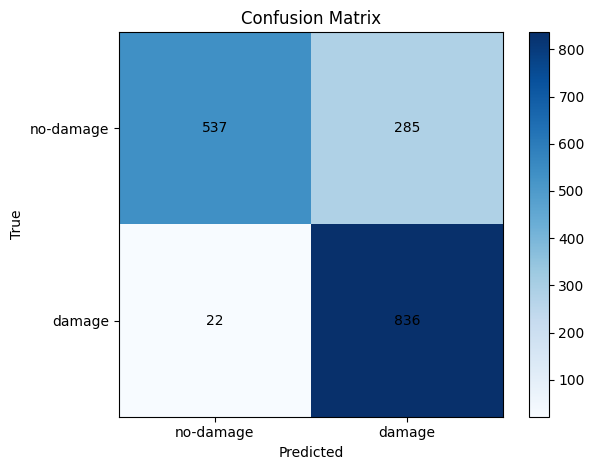

In [57]:
# cell: ROC-AUC + confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

model.eval()
probs_list, true_list = [], []
with torch.no_grad():
    for xb,yb in val_dl:
        xb = xb.to(device)
        probs = model(xb).softmax(1)[:,1].cpu().numpy()
        probs_list.append(probs); true_list.append(yb.numpy())
y_prob = np.concatenate(probs_list); y_true = np.concatenate(true_list)
y_pred = (y_prob>=0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_true, y_prob))
print(classification_report(y_true, y_pred, target_names=["no-damage","damage"], digits=3))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks([0,1], ["no-damage","damage"]); plt.yticks([0,1], ["no-damage","damage"])
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j], ha="center", va="center", color="black")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

In [1]:
# A (config/dataset)

# B (train 8–10 epochs, saves best model)

# C (collect scores, sweep threshold, confusion matrix @ τ*)

# (Optional) D (mine hard negatives, then a short fine-tune)

# E (save meta JSON)

# (Optional) F (CSV export for report)

In [3]:
# --- Cell A: config & dataset helpers ---

import os, json, math, numpy as np
from pathlib import Path
from typing import Optional, Tuple, List

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image

# ---- config
DATA_DIR   = "disaster-ai/data/xbd/tier1"  # your tier1 folder
IMG_SIZE   = 256                           # try 256 (224 also fine)
AREA_MIN   = 80                            # ignore tiny specks (50–120 is typical)
BATCH_TR   = 16                            # batch size for train
BATCH_VAL  = 32                            # batch size for val/inference
SEED       = 42
DEVICE     = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", DEVICE)

# ---- dataset (binary: damage vs no-damage using *_rgb.png masks)
class XBDMaskBinaryDataset(Dataset):
    def __init__(self, root:str, split:str="train",
                 img_size:int=224, seed:int=42, limit:int|None=None,
                 aug:bool=False, area_min:int=50):
        self.root = Path(root)
        self.area_min = int(area_min)
        # collect post-disaster tiles
        self.imgs: List[Path] = sorted(self.root.rglob("*post*disaster*.png"))
        if not self.imgs:
            raise FileNotFoundError(f"No post-disaster PNGs under {self.root}")

        g = torch.Generator().manual_seed(seed)
        perm = torch.randperm(len(self.imgs), generator=g).tolist()
        n = int(0.8*len(self.imgs))
        self.imgs = [self.imgs[i] for i in perm[:n]] if split=="train" else [self.imgs[i] for i in perm[n:]]
        if limit: self.imgs = self.imgs[:limit]

        # transforms
        mean, std = [0.485,0.456,0.406],[0.229,0.224,0.225]
        if aug:
            self.tf = transforms.Compose([
                transforms.RandomResizedCrop(img_size, scale=(0.9,1.0), ratio=(0.9,1.1)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(12),
                transforms.ColorJitter(0.2,0.2,0.2,0.05),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        else:
            self.tf = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])

    def __len__(self): return len(self.imgs)

    def _mask_path(self, p:Path) -> Path:
        # masks are in sibling "masks/" named *_rgb.png
        return p.parent.parent/"masks"/(p.stem + "_rgb.png")

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        ip = self.imgs[idx]
        mp = self._mask_path(ip)
        x  = Image.open(ip).convert("RGB")
        if not mp.exists():
            y = 0
        else:
            m = Image.open(mp).convert("L")
            # label = 1 if number of positive pixels >= area_min
            pos = (np.array(m) > 0).sum()
            y = 1 if pos >= self.area_min else 0
        return self.tf(x), torch.tensor(y, dtype=torch.long)


def create_binary_loaders(data_dir:str,
                          img_size:int=224,
                          batch_tr:int=16,
                          batch_val:int=32,
                          limit:int|None=None,
                          area_min:int=50):
    ds_tr = XBDMaskBinaryDataset(data_dir, "train", img_size, SEED, limit, aug=True,  area_min=area_min)
    ds_va = XBDMaskBinaryDataset(data_dir, "val",   img_size, SEED, limit, aug=False, area_min=area_min)

    # class weights for CE + sampler
    labels = torch.tensor([int(y) for _, y in ds_tr], dtype=torch.long)
    counts = torch.bincount(labels, minlength=2).float()
    class_weights = (1.0/(counts+1e-6)) * (2/(1.0/(counts+1e-6)).sum())  # ~normalize around 1
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    tr_dl = DataLoader(ds_tr, batch_size=batch_tr, sampler=sampler, num_workers=0)
    va_dl = DataLoader(ds_va, batch_size=batch_val, shuffle=False, num_workers=0)
    print("Train counts:", counts.tolist(), "| class_weights:", class_weights.tolist())
    return tr_dl, va_dl, class_weights

Device: mps


In [5]:
# --- Cell B: train (pretrained ResNet18 + cosine) ---

import time, torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

torch.manual_seed(SEED)
train_dl, val_dl, class_w = create_binary_loaders(DATA_DIR, img_size=IMG_SIZE,
                                                  batch_tr=BATCH_TR, batch_val=BATCH_VAL,
                                                  limit=None, area_min=AREA_MIN)

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(DEVICE)

opt   = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
loss_fn = nn.CrossEntropyLoss(weight=class_w.to(DEVICE))

best = 0.0
EPOCHS = 10
os.makedirs("disaster-ai/models/cv", exist_ok=True)

for ep in range(1, EPOCHS+1):
    t0=time.time()
    model.train(); total=0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward(); opt.step()
        total += loss.item() * xb.size(0)
    tr_loss = total / len(train_dl.dataset)
    sched.step()

    # val
    model.eval(); correct=0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb).argmax(1)
            correct += (pred==yb).sum().item()
    val_acc = correct / len(val_dl.dataset)
    print(f"epoch {ep:02d} | train_loss {tr_loss:.4f} | val_acc {val_acc:.3f} | time {time.time()-t0:.1f}s")

    if val_acc > best:
        best = val_acc
        torch.save(model.state_dict(), "disaster-ai/models/cv/resnet18_xbd_binary.pt")

print("Best val_acc:", best)

Train counts: [3123.0, 3593.0] | class_weights: [1.0699821710586548, 0.9300178289413452]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/rudrabrahmbhatt/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████████████████████████████████| 44.7M/44.7M [00:24<00:00, 1.89MB/s]


epoch 01 | train_loss 0.3346 | val_acc 0.942 | time 272.2s
epoch 02 | train_loss 0.2867 | val_acc 0.962 | time 270.1s
epoch 03 | train_loss 0.2604 | val_acc 0.945 | time 269.4s
epoch 04 | train_loss 0.2457 | val_acc 0.954 | time 268.1s
epoch 05 | train_loss 0.2254 | val_acc 0.954 | time 271.5s
epoch 06 | train_loss 0.2318 | val_acc 0.970 | time 315.3s
epoch 07 | train_loss 0.2180 | val_acc 0.971 | time 286.8s
epoch 08 | train_loss 0.2010 | val_acc 0.976 | time 299.5s
epoch 09 | train_loss 0.1964 | val_acc 0.976 | time 298.0s
epoch 10 | train_loss 0.1922 | val_acc 0.979 | time 280.4s
Best val_acc: 0.9791542584871947


Best τ by macro-F1: 0.5 | macro-F1: 0.9791158541461062
              precision    recall  f1-score   support

   no-damage      0.973     0.984     0.978       799
      damage      0.985     0.975     0.980       880

    accuracy                          0.979      1679
   macro avg      0.979     0.979     0.979      1679
weighted avg      0.979     0.979     0.979      1679



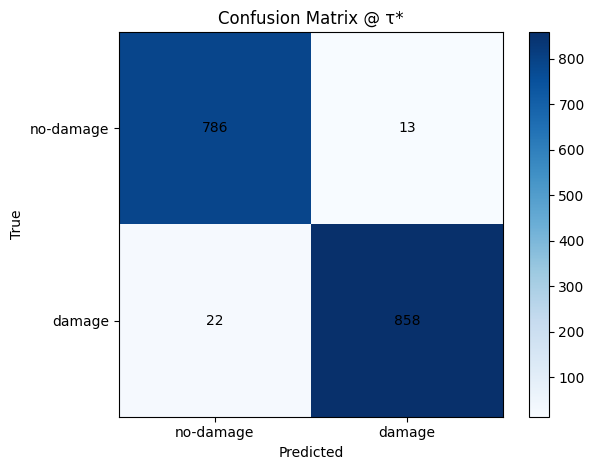

In [7]:
# --- Cell C: collect y_true & y_prob on val, sweep threshold ---

from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# reload best
model.load_state_dict(torch.load("disaster-ai/models/cv/resnet18_xbd_binary.pt", map_location=DEVICE))
model.eval()

y_true, y_prob = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(DEVICE)
        probs = model(xb).softmax(1)[:,1].cpu().numpy()   # P(damage)
        y_prob.append(probs)
        y_true.append(yb.numpy())

y_true = np.concatenate(y_true)
y_prob = np.concatenate(y_prob)

taus = np.linspace(0.1, 0.9, 33)
macro_f1 = []
for t in taus:
    y_pred = (y_prob >= t).astype(int)
    macro_f1.append(f1_score(y_true, y_pred, average="macro"))

t_star = float(taus[int(np.argmax(macro_f1))])
print("Best τ by macro-F1:", t_star, "| macro-F1:", float(np.max(macro_f1)))

# plot confusion at τ*
y_pred = (y_prob >= t_star).astype(int)
print(classification_report(y_true, y_pred, target_names=["no-damage","damage"], digits=3, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks([0,1], ["no-damage","damage"]); plt.yticks([0,1], ["no-damage","damage"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black")
plt.title("Confusion Matrix @ τ*"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

In [9]:
# --- Cell D: mine hard negatives (simple) and rebuild train_dl ---

def mine_hard_negatives(ds: XBDMaskBinaryDataset, model, top_ratio:float=0.05):
    # score only negatives (y==0), keep highest-scored subset
    model.eval()
    idxs, scores = [], []
    with torch.no_grad():
        for i in range(len(ds)):
            x, y = ds[i]
            if int(y) != 0: 
                continue
            p = model(x.unsqueeze(0).to(DEVICE)).softmax(1)[0,1].item()
            idxs.append(i); scores.append(p)
    if not scores: 
        return []
    k = max(1, int(len(scores)*top_ratio))
    hard_idx_sorted = np.argsort(scores)[-k:]  # top K
    return [idxs[j] for j in hard_idx_sorted]

# Rebuild loaders with boosted weights for mined negatives
ds_tr = XBDMaskBinaryDataset(DATA_DIR, "train", IMG_SIZE, SEED, None, aug=True, area_min=AREA_MIN)
hard_idx = mine_hard_negatives(ds_tr, model, top_ratio=0.05)
print("Mined hard negatives:", len(hard_idx))

labels = torch.tensor([int(y) for _, y in ds_tr], dtype=torch.long)
counts = torch.bincount(labels, minlength=2).float()
class_w = (1.0/(counts+1e-6)) * (2/(1.0/(counts+1e-6)).sum())
sample_w = class_w[labels]

# boost mined negatives ×3
boost = 3.0
for i in hard_idx:
    sample_w[i] *= boost

sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)
train_dl = DataLoader(ds_tr, batch_size=BATCH_TR, sampler=sampler, num_workers=0)
print("class counts:", counts.tolist())

Mined hard negatives: 156
class counts: [3123.0, 3593.0]


In [13]:
# ---- setup device ----
import torch

device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
print("Using device:", device)

# ---- fine-tune with mined sampler: 3–5 epochs & track no-damage recall ----
import time
from torch import nn

opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5)

EPOCHS_FT = 5
best_nd_recall = -1.0
save_path = "disaster-ai/models/cv/resnet18_xbd_binary_mined.pt"

def per_class_counts(y_true, y_pred, n_classes=2):
    tp = torch.zeros(n_classes, dtype=torch.long)
    fn = torch.zeros(n_classes, dtype=torch.long)
    fp = torch.zeros(n_classes, dtype=torch.long)
    for c in range(n_classes):
        tp[c] = ((y_true == c) & (y_pred == c)).sum()
        fn[c] = ((y_true == c) & (y_pred != c)).sum()
        fp[c] = ((y_true != c) & (y_pred == c)).sum()
    return tp, fn, fp

for ep in range(EPOCHS_FT):
    t0 = time.time()

    # ---- train ----
    model.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    tr_loss = total_loss / len(train_dl.dataset)
    sched.step()

    # ---- validate ----
    model.eval()
    correct = 0
    all_true, all_pred = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            correct += (preds == yb).sum().item()
            all_true.append(yb.cpu())
            all_pred.append(preds.cpu())

    y_true = torch.cat(all_true)
    y_pred = torch.cat(all_pred)
    acc = correct / len(val_dl.dataset)

    tp, fn, fp = per_class_counts(y_true, y_pred, n_classes=2)
    eps = 1e-9
    recall_nd = (tp[0].float() / (tp[0] + fn[0] + eps).float()).item()
    recall_dmg = (tp[1].float() / (tp[1] + fn[1] + eps).float()).item()

    print(f"ep {ep+1:02d} | train_loss {tr_loss:.4f} | val_acc {acc:.3f} | "
          f"recall(no-damage) {recall_nd:.3f} | recall(damage) {recall_dmg:.3f} | "
          f"time {time.time()-t0:.1f}s")

    if recall_nd > best_nd_recall:
        best_nd_recall = recall_nd
        torch.save(model.state_dict(), save_path)
        print(f"  ↑ saved best (no-damage recall) to {save_path}")

print(f"Best no-damage recall achieved: {best_nd_recall:.3f}")

Using device: mps
ep 01 | train_loss 0.2400 | val_acc 0.954 | recall(no-damage) 0.994 | recall(damage) 0.917 | time 273.3s
  ↑ saved best (no-damage recall) to disaster-ai/models/cv/resnet18_xbd_binary_mined.pt
ep 02 | train_loss 0.2456 | val_acc 0.945 | recall(no-damage) 0.995 | recall(damage) 0.899 | time 281.7s
  ↑ saved best (no-damage recall) to disaster-ai/models/cv/resnet18_xbd_binary_mined.pt
ep 03 | train_loss 0.2215 | val_acc 0.959 | recall(no-damage) 0.992 | recall(damage) 0.930 | time 286.9s
ep 04 | train_loss 0.2108 | val_acc 0.968 | recall(no-damage) 0.992 | recall(damage) 0.945 | time 284.5s
ep 05 | train_loss 0.2069 | val_acc 0.974 | recall(no-damage) 0.991 | recall(damage) 0.958 | time 285.4s
Best no-damage recall achieved: 0.995


In [15]:
# --- Cell E: save tuned threshold & meta ---

meta = {"threshold": t_star, "img_size": IMG_SIZE, "area_min": AREA_MIN}
os.makedirs("disaster-ai/models/cv", exist_ok=True)
with open("disaster-ai/models/cv/resnet18_xbd_binary_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved:", meta)

Saved: {'threshold': 0.5, 'img_size': 256, 'area_min': 80}


In [19]:
import csv, os
import numpy as np
from pathlib import Path

def export_eval_csv(val_loader, y_true, y_prob, threshold,
                    out_csv="disaster-ai/models/cv/val_scores.csv"):
    """
    Same as above, but we compute the exact batch sizes from val_loader and
    split y_true/y_prob using those boundaries.
    """
    y_pred = (y_prob >= threshold).astype(int)

    # get batch sizes (iterate once without grad)
    batch_sizes = []
    for xb, yb in val_loader:
        batch_sizes.append(len(yb))

    # compute split indices
    cut_idx = np.cumsum(batch_sizes)[:-1]  # boundaries between batches

    y_true_chunks = np.split(y_true, cut_idx)
    y_prob_chunks = np.split(y_prob, cut_idx)

    os.makedirs(Path(out_csv).parent, exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["row_index", "y_true", "y_prob", "y_pred"])

        row = 0
        for probs_chunk, y_chunk in zip(y_prob_chunks, y_true_chunks):
            for p, t in zip(probs_chunk, y_chunk):
                w.writerow([row, int(t), float(p), int(p >= threshold)])
                row += 1

    print("Wrote:", out_csv)